In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 9.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import json
import random
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import re
import numpy as np
import emoji
# from transformers import *
from tqdm import tqdm
# from sklearn.model_selection import StratifiedKFold
# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *
from sklearn.utils import *
import pandas as pd
import string

In [79]:
# d1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_hi_l1.csv')
# d11 = pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_hi_l1.csv', encoding="latin1")
d1_test = pd.read_csv(
    '/content/drive/MyDrive/NLP_Project/NLP/testing/test_hi_l1.csv',
    # on_bad_lines='skip',
    engine='python'
)

d1_test

,text,key,hi_a1,hi_a2,hi_a3,hi_a4,hi_a5
0,#BandraStation #SharadPawar #Muradabad अगर अभ...,question_1,NaN,0.0,0.0,0.0,NaN
1,#ConspiracyAgainstIndia सुन लो रे देश के गद्द...,question_1,NaN,0.0,0.0,0.0,NaN
2,#MarathaReservation : महाराष्ट्र में जश्न का म...,question_1,0.0,0.0,0.0,NaN,NaN
3,#RheaChakraborty aap Mahesh bhatt se madad kiy...,question_1,NaN,1.0,1.0,0.0,NaN
4,"#SecularMaskOfd हमे पता नहि क्या कहते है ,इतना...",question_1,0.0,NaN,1.0,0.0,NaN
...,...,...,...,...,...,...,...
1512,है हैवान लोग होते हैं इनको ओसामा लादेन खतरनाक ...,question_1,NaN,0.0,NaN,0.0,1.0
1513,"🇮🇳जय हिन्द,🇮🇳जय भारत,🇮🇳वन्दे मातरम🇮🇳🇮🇳 बघेल तु...",question_1,NaN,0.0,NaN,1.0,1.0
1514,🙏जय भीम 🙏 जो लोग हमें धमकियां देते है और संव...,question_1,0.0,NaN,NaN,0.0,0.0
1515,🚩🕉🚩 *इंसान के पास 😇दिमाग होना चाहिये* *💀खोपड़...,question_1,0.0,NaN,0.0,0.0,NaN


In [80]:
def normalize_text(text):
  # emoji_pattern = re.compile("["
  #                             u"\U0001F600-\U0001F64F"  # emoticons
  #                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
  #                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
  #                             u"\U0001F700-\U0001F77F"  # alchemical symbols
  #                             u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
  #                             u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
  #                             u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
  #                             u"\U0001FA00-\U0001FA6F"  # Chess Symbols
  #                             u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
  #                             u"\U00002702-\U000027B0"  # Dingbats
  #                             u"\U000024C2-\U0001F251"
  #                             "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji.demojize(text)
  text = text.replace("ðŸ¤§", " ")
  text = text.replace("&amp;", " ")
  text = text.replace("\n", " ")
  text = text.replace("ðŸ˜¡", " ")
  # text = emoji_pattern.sub(r'', text)
  return text

# d1['text'] = d1['text'].apply(lambda x: normalize_text(x))
d1_test['text'] = d1_test['text'].apply(lambda x: normalize_text(x))

In [81]:
d1_test

,text,key,hi_a1,hi_a2,hi_a3,hi_a4,hi_a5
0,bandrastation sharadpawar muradabad अगर अभ...,question_1,NaN,0.0,0.0,0.0,NaN
1,conspiracyagainstindia सुन लो रे देश के गद्द...,question_1,NaN,0.0,0.0,0.0,NaN
2,marathareservation महाराष्ट्र में जश्न का म...,question_1,0.0,0.0,0.0,NaN,NaN
3,rheachakraborty aap mahesh bhatt se madad kiy...,question_1,NaN,1.0,1.0,0.0,NaN
4,secularmaskofd हमे पता नहि क्या कहते है इतना...,question_1,0.0,NaN,1.0,0.0,NaN
...,...,...,...,...,...,...,...
1512,है हैवान लोग होते हैं इनको ओसामा लादेन खतरनाक ...,question_1,NaN,0.0,NaN,0.0,1.0
1513,:India:जय हिन्द :India:जय भारत :India:वन्दे मा...,question_1,NaN,0.0,NaN,1.0,1.0
1514,:folded_hands:जय भीम :folded_hands: जो लोग हम...,question_1,0.0,NaN,NaN,0.0,0.0
1515,:triangular_flag::om::triangular_flag: इंसान ...,question_1,0.0,NaN,0.0,0.0,NaN


In [82]:
# X1 = list(d1['text'])
X1_test = list(d1_test['text'])

col_lst = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']
for col in col_lst:
    # d1[col] = pd.to_numeric(d1[col], errors='coerce')
    d1_test[col] = pd.to_numeric(d1_test[col], errors='coerce')



# d1['label'] = d1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

# d1_test = d1_test.dropna(subset=col_lst)
# d1_test['label'] = d1_test[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
d1_test['label'] = d1_test[col_lst].max(axis=1, skipna=True).fillna(0).astype(int)



# d1 = d1.drop(col_lst, axis=1)
d1_test = d1_test.drop(col_lst, axis=1)


# d1['label'] = d1['label'].astype(int)
d1_test['label'] = d1_test['label'].astype(int)


# d1 = d1[['label', 'text']]
d1_test = d1_test[['label', 'text']]
d1_test

,label,text
0,0,bandrastation sharadpawar muradabad अगर अभ...
1,0,conspiracyagainstindia सुन लो रे देश के गद्द...
2,0,marathareservation महाराष्ट्र में जश्न का म...
3,1,rheachakraborty aap mahesh bhatt se madad kiy...
4,1,secularmaskofd हमे पता नहि क्या कहते है इतना...
...,...,...
1512,1,है हैवान लोग होते हैं इनको ओसामा लादेन खतरनाक ...
1513,1,:India:जय हिन्द :India:जय भारत :India:वन्दे मा...
1514,0,:folded_hands:जय भीम :folded_hands: जो लोग हम...
1515,0,:triangular_flag::om::triangular_flag: इंसान ...


In [83]:
# y_data1 = d1["label"]
# y1 = y_data1.values

# print(y1)
# print(len(y1))

In [84]:
# def getPerformanceOfLoader(test_dataloader):
#     model.eval()
#     # Tracking variables
#     predictions , true_labels = [], []
#     # Predict
#     for batch in test_dataloader:
#     #print(batch)
#     # Add batch to GPU
#         batch = tuple(t.to(device) for t in batch)

#         # Unpack the inputs from our dataloader
#         b_input_ids, b_input_mask, b_labels = batch

#         # Telling the model not to compute or store gradients, saving memory and
#         # speeding up prediction
#         with torch.no_grad():
#             # Forward pass, calculate logit predictions
#             outputs = model(b_input_ids, token_type_ids=None,
#                       attention_mask=b_input_mask)

#         logits = outputs[0]

#         # Move logits and labels to CPU
#         logits = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()
#         # Store predictions and true labels
#         pred_flat = np.argmax(logits, axis=1).flatten()
#         predictions.extend(pred_flat)
#         true_labels.extend(label_ids)

#     df = pd.DataFrame()
#     df['id']=testData['text']
#     df['target'] = predictions

#     return df

In [85]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load the tokenizer and model
model_name = "Hate-speech-CNERG/hindi-abusive-MuRIL"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

def get_predictions(df):
    y_true = df['label'].tolist()
    y_pred = []

    for text in tqdm(df['text'], desc="Predicting"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)
            pred = torch.argmax(probs, dim=1).item()
            y_pred.append(pred)

    return y_true, y_pred

In [86]:
def evalMetric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    mf1Score = f1_score(y_true, y_pred, average='macro')
    f1Score  = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    area_under_c = auc(fpr, tpr)
    recallScore = recall_score(y_true, y_pred)
    precisionScore = precision_score(y_true, y_pred)
    return {"accuracy": accuracy, 'mF1Score': mf1Score, 'f1Score': f1Score, 'auc': area_under_c,
            'precision': precisionScore, 'recall': recallScore}



In [87]:
# d1_subset = d1.head(200)
y_true, y_pred = get_predictions(d1_test)



Predicting: 100%|██████████| 1517/1517 [04:54<00:00,  5.15it/s]


In [88]:
# Evaluate
import numpy as np

classes, counts = np.unique(y_true, return_counts=True)
print("Predicted class distribution:")
for cls, count in zip(classes, counts):
    print(f"Class {cls}: {count}")

metrics = evalMetric(y_true, y_pred)
print("Evaluation Metrics:\n", metrics)

Predicted class distribution:
Class 0: 829
Class 1: 688
Evaluation Metrics:
 {'accuracy': 0.6974291364535267, 'macro_f1': 0.6966270986687464, 'weighted_f1': 0.6980769362027723, 'auc': np.float64(0.6986860745644796), 'precision': 0.6969888712352199, 'recall': 0.6986860745644795}


In [89]:
# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, labels=["Not Hate", "Hate"]):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

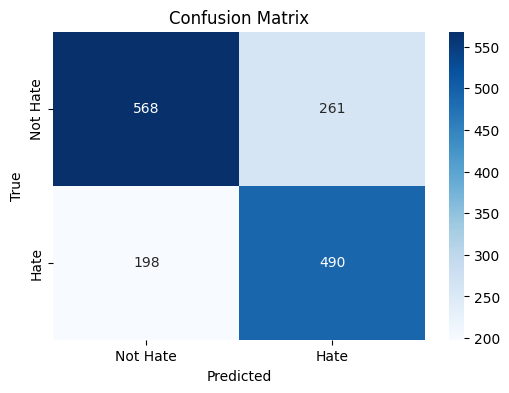

In [90]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)